# Hypothese 5


In [ ]:
import ast
import json
import os

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pyarrow.parquet as pq
from matplotlib.patches import FancyBboxPatch
from scipy import stats
from scipy.stats import t
from sklearn.preprocessing import MinMaxScaler

## Daten einlesen

In [2]:
parquet_file = "data/input/Data_OpenAlex.parquet"

In [3]:
df = pd.read_parquet(parquet_file)
print(f"{len(df):,} Paper geladen")

# Entferne Zeilen ohne country_codes oder institutions
df_clean = df.dropna(subset=['country_codes', 'institutions', 'fwci']).copy()
print(f"Nach Bereinigung: {len(df_clean):,} Paper")

16,751,942 Paper geladen
Nach Bereinigung: 14,477,827 Paper


In [4]:
def parse_institutions(institutions_str):
    """Parse institutions JSON string and return unique institution names"""
    try:
        if pd.isna(institutions_str) or institutions_str == '':
            return []
        
        # String zu Liste von Dictionaries konvertieren
        institutions_list = ast.literal_eval(institutions_str)
        
        # Unique institution names extrahieren
        unique_names = set()
        for inst in institutions_list:
            if isinstance(inst, dict) and 'name' in inst:
                unique_names.add(inst['name'])
        
        return list(unique_names)
    except:
        return []

def has_multiple_institutions(institutions_str):
    """Check if paper has multiple different institutions"""
    institutions = parse_institutions(institutions_str)
    return len(institutions) > 1

def parse_country_codes(country_codes_str):
    """Parse country codes string into list"""
    if pd.isna(country_codes_str) or country_codes_str == '':
        return []
    return [code.strip() for code in country_codes_str.split(',')]

# Test der Funktionen mit Sample-Daten
sample_institutions = df_clean['institutions'].iloc[0]
sample_countries = df_clean['country_codes'].iloc[0]

print(f"Test mit einem Paper")
print(f"Institutionen: {parse_institutions(sample_institutions)}")
print(f"Länder: {parse_country_codes(sample_countries)}")
print(f"Mehrere Institutionen: {has_multiple_institutions(sample_institutions)}")

Test mit einem Paper
Institutionen: ['American Cancer Society', 'Centre international de recherche sur le cancer']
Länder: ['FR', 'US']
Mehrere Institutionen: True


## Aggregation nach Ländern

In [5]:
# Neue Spalten für die Analyse hinzufügen
df_clean['has_multiple_institutions'] = df_clean['institutions'].apply(has_multiple_institutions)
df_clean['country_list'] = df_clean['country_codes'].apply(parse_country_codes)

# Explode DataFrame für Länder-basierte Analyse
# Jedes Paper wird für jedes Land dupliziert
if os.path.exists('data/cache/Hypothese5_df_exploded_cleaned.parquet'):
    df_exploded = pd.read_parquet('data/cache/Hypothese5_df_exploded_cleaned.parquet')
    print("DataFrame erfolgreich geladen.")
else:
    print("Cached Dataframe nicht gefunden, starte Berechnung")
    df_exploded = df_clean.explode('country_list')
    df_exploded = df_exploded[df_exploded['country_list'].notna() & (df_exploded['country_list'] != '')]
    df_exploded.to_parquet('data/cache/Hypothese5_df_exploded_cleaned.parquet')

print(f"Nach Länder-Aufteilung: {len(df_exploded):,} Paper-Land-Kombinationen")
print(f"Einzigartige Länder: {df_exploded['country_list'].nunique()}")

DataFrame erfolgreich geladen.
Nach Länder-Aufteilung: 22,699,454 Paper-Land-Kombinationen
Einzigartige Länder: 226


In [6]:
# Aggregation nach Ländern
country_stats = df_exploded.groupby('country_list').agg({
    'paper_id': 'count',  # Gesamtanzahl Paper pro Land
    'has_multiple_institutions': 'sum',  # Anzahl Paper mit mehreren Institutionen
    'fwci': 'median'  # Median FWCI pro Land
}).round(3)

country_stats.columns = ['total_papers', 'multi_institution_papers', 'median_fwci']

# Rate berechnen mit Anteil der Paper mit mehreren Institutionen
country_stats['multi_institution_rate'] = (
    country_stats['multi_institution_papers'] / country_stats['total_papers']
).round(4)


print("Top 10 Länder nach Gesamtanzahl Paper:")
country_stats.sort_values('total_papers', ascending=False).head(10)

Top 10 Länder nach Gesamtanzahl Paper:


,total_papers,multi_institution_papers,median_fwci,multi_institution_rate
country_list,,,,
GB,2594093,1759981,0.776,0.6785
DE,2308544,1459758,0.623,0.6323
FR,1620999,1133186,0.380,0.6991
IT,1437870,958012,0.798,0.6663
US,1418657,1345307,1.055,0.9483
RU,1392481,667097,0.124,0.4791
ES,1340736,834882,0.585,0.6227
PL,798628,369313,0.285,0.4624
NL,751278,554058,1.017,0.7375


## Regressionsanalyse

In [7]:
# EU-27 Mitgliedsstaaten
eu_countries = {
    'AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 
    'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 
    'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE'
}

# Für Visualisierung: Nur EU-Länder aus den bereits berechneten gefilterten Daten
chart_data = country_stats[country_stats.index.isin(eu_countries)].copy()

print(f"EU-Länder für Visualisierung: {len(chart_data)}")
print(f"EU-Länder in Chart: {sorted(list(chart_data.index))}")

EU-Länder für Visualisierung: 27
EU-Länder in Chart: ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']


In [8]:
# Normalisierung nur basierend auf EU-Ländern für bessere Skalierung
# X-Achse: Multi-Institution Rate normalisiert (0 = niedrigster EU-Wert, 1 = höchster EU-Wert)
x_min = chart_data['multi_institution_rate'].min()
x_max = chart_data['multi_institution_rate'].max()
chart_data['x_normalized'] = (chart_data['multi_institution_rate'] - x_min) / (x_max - x_min)

# Y-Achse: Median FWCI
chart_data['y_axis'] = chart_data['median_fwci']

# Bubble-Größe: Einheitliche Größe für alle Bubbles
chart_data['bubble_size'] = 30  # Alle Bubbles gleich groß

In [ ]:
# EU-Länder mit Flaggen-Emojis
country_flags = {
    'AT': '🇦🇹', 'BE': '🇧🇪', 'BG': '🇧🇬', 'HR': '🇭🇷', 'CY': '🇨🇾', 
    'CZ': '🇨🇿', 'DK': '🇩🇰', 'EE': '🇪🇪', 'FI': '🇫🇮', 'FR': '🇫🇷',
    'DE': '🇩🇪', 'GR': '🇬🇷', 'HU': '🇭🇺', 'IE': '🇮🇪', 'IT': '🇮🇹',
    'LV': '🇱🇻', 'LT': '🇱🇹', 'LU': '🇱🇺', 'MT': '🇲🇹', 'NL': '🇳🇱',
    'PL': '🇵🇱', 'PT': '🇵🇹', 'RO': '🇷🇴', 'SK': '🇸🇰', 'SI': '🇸🇮',
    'ES': '🇪🇸', 'SE': '🇸🇪'
}

# Flaggen zu den Chart-Daten hinzufügen
chart_data['flag'] = chart_data.index.map(country_flags)
chart_data['country_with_flag'] = chart_data.index + ' ' + chart_data['flag']

print(f"X-Achse (Multi-Institution Rate): {x_min:.3f} bis {x_max:.3f}")
print(f"Y-Achse (Median FWCI): {chart_data['y_axis'].min():.1f} bis {chart_data['y_axis'].max():.1f}")

X-Achse (Multi-Institution Rate): 0.462 bis 0.958
Y-Achse (Median FWCI): 0.2 bis 1.1


In [21]:
x_vals = chart_data['x_normalized'].values
y_vals = chart_data['y_axis'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals, y_vals)


print(f"Regressionsstatistiken:")
print(f"   Korrelation (R): {r_value:.3f}")
print(f"   Bestimmtheitsmaß (R²): {r_value**2:.3f}")
print(f"   p-Wert: {p_value:.3f}")
print(f"   Steigung: {slope:.3f}")
print(f"   Achsenabschnitt: {intercept:.3f}")

if p_value < 0.05:
    signifikanz = "statistisch signifikant"
else:
    signifikanz = "nicht statistisch signifikant"
print(f"   Signifikanz: {signifikanz} (p {'<' if p_value < 0.05 else '>='} 0.05)")


Regressionsstatistiken:
   Korrelation (R): 0.847
   Bestimmtheitsmaß (R²): 0.718
   p-Wert: 0.000
   Steigung: 1.149
   Achsenabschnitt: 0.193
   Signifikanz: statistisch signifikant (p < 0.05)


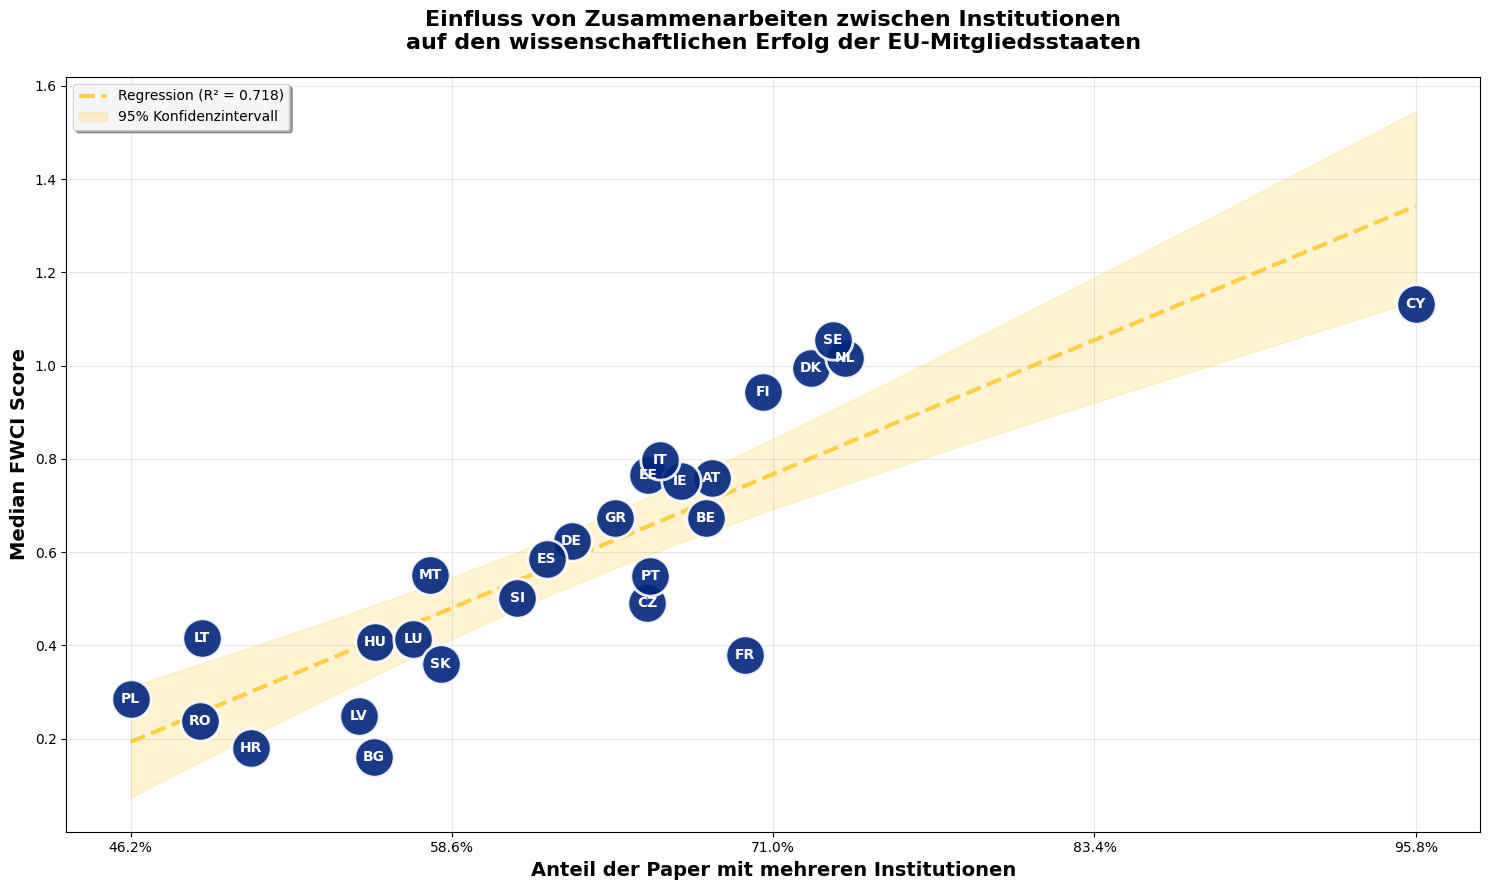

In [23]:
# Matplotlib Plot erstellen
fig, ax = plt.subplots(figsize=(15, 9))

# EU-Farben
eu_blue = '#00257C'
eu_gold = '#FFC620'

# Scatter Plot erstellen
x_vals = chart_data['x_normalized'].values
y_vals = chart_data['y_axis'].values

# Scatterplot
scatter = ax.scatter(x_vals, y_vals, 
                    s=800,
                    c=eu_blue, 
                    alpha=0.9, 
                    edgecolors='white', 
                    linewidth=2,
                    zorder=3)

# Country Codes als Text hinzufügen
for i, (country, row) in enumerate(chart_data.iterrows()):
    ax.text(row['x_normalized'], row['y_axis'], country, 
           ha='center', va='center', 
           fontsize=10, fontweight='bold', 
           color='white', zorder=4)

# Regressionslinie hinzufügen
x_line = np.linspace(0, 1, 100)
y_line = slope * x_line + intercept

ax.plot(x_line, y_line, color=eu_gold, linewidth=3, 
        linestyle='--', alpha=0.8, zorder=2,
        label=f'Regression (R² = {r_value**2:.3f})')

# Konfidenzintervall
n = len(x_vals)
dof = n - 2
t_val = stats.t.ppf(0.975, dof)
residuals = y_vals - (slope * x_vals + intercept)
s_err = np.sqrt(np.sum(residuals**2) / dof)
x_mean = np.mean(x_vals)
s_x = np.sqrt(np.sum((x_vals - x_mean)**2))
se_line = s_err * np.sqrt(1/n + (x_line - x_mean)**2 / s_x**2)
ci_upper = y_line + t_val * se_line
ci_lower = y_line - t_val * se_line

ax.fill_between(x_line, ci_lower, ci_upper, 
               color=eu_gold, alpha=0.2, zorder=1,
               label='95% Konfidenzintervall')

# Achsen und Layout
ax.set_xlabel('Anteil der Paper mit mehreren Institutionen', fontsize=14, fontweight='bold')
ax.set_ylabel('Median FWCI Score', fontsize=14, fontweight='bold')
ax.set_title('Einfluss von Zusammenarbeiten zwischen Institutionen\nauf den wissenschaftlichen Erfolg der EU-Mitgliedsstaaten', 
            fontsize=16, fontweight='bold', pad=20)

# X-Achse Formatierung
x_min = chart_data['multi_institution_rate'].min()
x_max = chart_data['multi_institution_rate'].max()
ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels([f'{x_min:.1%}', f'{x_min + 0.25*(x_max-x_min):.1%}', 
                   f'{x_min + 0.5*(x_max-x_min):.1%}', f'{x_min + 0.75*(x_max-x_min):.1%}', f'{x_max:.1%}'])

# Grid und Styling
ax.grid(True, alpha=0.3, zorder=0)
ax.set_facecolor('white')
ax.legend(loc='upper left', framealpha=0.9, fancybox=True, shadow=True)

# Layout optimieren
plt.tight_layout()

# Als SVG speichern
plt.savefig("data/output/Hypothese_5.svg", format='svg', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')

plt.show()

## Zusammenfassung

In [26]:
# Top 10 Listen erstellen
print("Top 10 EU Länder mit höchster Multi-Institution Rate:")
top_collaboration = chart_data.sort_values('multi_institution_rate', ascending=False).head(10)
for i, (country, row) in enumerate(top_collaboration.iterrows(), 1):
    print(f"{i:2d}. {country}: {row['multi_institution_rate']:.1%} ({row['multi_institution_papers']:,}/{row['total_papers']:,} Paper)")

Top 10 EU Länder mit höchster Multi-Institution Rate:
 1. CY: 95.8% (19,477/20,339 Paper)
 2. NL: 73.8% (554,058/751,278 Paper)
 3. SE: 73.3% (362,612/494,766 Paper)
 4. DK: 72.5% (257,660/355,662 Paper)
 5. FI: 70.6% (185,290/262,444 Paper)
 6. FR: 69.9% (1,133,186/1,620,999 Paper)
 7. AT: 68.6% (227,187/330,962 Paper)
 8. BE: 68.4% (318,940/466,293 Paper)
 9. IE: 67.4% (132,745/196,865 Paper)
10. IT: 66.6% (958,012/1,437,870 Paper)


In [27]:
print("Top 10 Länder mit höchstem Median FWCI:")
top_impact = chart_data.sort_values('median_fwci', ascending=False).head(10)
for i, (country, row) in enumerate(top_impact.iterrows(), 1):
    print(f"{i:2d}. {country}: FWCI {row['median_fwci']:.2f} "
          f"({row['total_papers']:,} Paper)")

Top 10 Länder mit höchstem Median FWCI:
 1. CY: FWCI 1.13 (20,339 Paper)
 2. SE: FWCI 1.05 (494,766 Paper)
 3. NL: FWCI 1.02 (751,278 Paper)
 4. DK: FWCI 0.99 (355,662 Paper)
 5. FI: FWCI 0.94 (262,444 Paper)
 6. IT: FWCI 0.80 (1,437,870 Paper)
 7. EE: FWCI 0.77 (41,670 Paper)
 8. AT: FWCI 0.76 (330,962 Paper)
 9. IE: FWCI 0.75 (196,865 Paper)
10. GR: FWCI 0.67 (256,485 Paper)


In [28]:
print("Top 10 EU Länder mit meisten Paper:")
top_volume = chart_data.sort_values('total_papers', ascending=False).head(10)
for i, (country, row) in enumerate(top_volume.iterrows(), 1):
    print(f"{i:2d}. {country}: {row['total_papers']:,} Paper "
          f"(Multi-Rate: {row['multi_institution_rate']:.1%}, FWCI: {row['median_fwci']:.2f})")

Top 10 EU Länder mit meisten Paper:
 1. DE: 2,308,544 Paper (Multi-Rate: 63.2%, FWCI: 0.62)
 2. FR: 1,620,999 Paper (Multi-Rate: 69.9%, FWCI: 0.38)
 3. IT: 1,437,870 Paper (Multi-Rate: 66.6%, FWCI: 0.80)
 4. ES: 1,340,736 Paper (Multi-Rate: 62.3%, FWCI: 0.58)
 5. PL: 798,628 Paper (Multi-Rate: 46.2%, FWCI: 0.28)
 6. NL: 751,278 Paper (Multi-Rate: 73.8%, FWCI: 1.02)
 7. SE: 494,766 Paper (Multi-Rate: 73.3%, FWCI: 1.05)
 8. BE: 466,293 Paper (Multi-Rate: 68.4%, FWCI: 0.67)
 9. PT: 393,877 Paper (Multi-Rate: 66.3%, FWCI: 0.55)
10. DK: 355,662 Paper (Multi-Rate: 72.5%, FWCI: 0.99)


In [30]:
# Korrelationsanalyse
correlation = chart_data['multi_institution_rate'].corr(chart_data['median_fwci'])
print(f"Korrelation in EU27:")
print(f"Multi-Institution Rate vs. Median FWCI: {correlation:.3f}")
if correlation > 0.3:
    print("Starke positive Korrelation: Mehr Kollaboration = höherer Impact")
elif correlation > 0.1:
    print("Schwache positive Korrelation: Leichte Tendenz mehr Kollaboration = höherer Impact")
elif correlation < -0.1:
    print("Negative Korrelation: Mehr Kollaboration = niedrigerer Impact")
else:
    print("Keine klare Korrelation erkennbar")

Korrelation in EU27:
Multi-Institution Rate vs. Median FWCI: 0.847
Starke positive Korrelation: Mehr Kollaboration = höherer Impact
